In [1]:
import sys, os
sys.path.extend([os.path.abspath('../')])
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot


Initializing the random number generator (for reproducibility). -- Disable if needed.

In [2]:
np.random.seed(210217)

## Li et al. 2017 model version
This model version is a simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley) , with a radiative and heat exchanges scheme inspired by the MAOOAM model.

More detail can be found in the articles:
* Li, D., He, Y., Huang, J., Bi, L., & Ding, L. (2018). *Multiple equilibria in a land–atmosphere coupled system.* Journal of Meteorological Research, **32**(6), 950-973.
[doi:10.1007/s13351-018-8012-y](https://doi.org/10.1007/s13351-018-8012-y)
* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)

or in the documentation.

Below I am loading Robin's parameters stored in a file called model1.pickle:

In [3]:
import pickle
# loading the model
with open('model1.pickle', "rb") as file:
    model = pickle.load(file)

f = model['f']
Df = model['Df']
model_parameters = model['parameters']
# Printing the model's parameters
model_parameters.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 0.353    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 112.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of t

/home/scratch01/gmiloshe/tests/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


Why did Robin choose n = 0.353? Otherwise the setup is similar to ground_heat.ipynb but with more spectral components. It is not clear to me if we need many spectral components. The typical setup with fewer components is usually enough to provide some realism. 

Parameters that are different:
* Atmospheric Temperature parameters
    * 'C[1]' : 122 [W][m^-2] instead of 99 [W][m^-2]: (spectral component 1 of the short-wave radiation of the atmosphere), other C's are zero
    * 'hlambda': 20  [W][m^-2][K^-1] instead of 10 [W][m^-2][K^-1] (sensible+turbulent heat exchange between ocean and atmosphere),
* Ground Parameters:
    * 'hk[2]': 0.4 instead of 0.2    (spectral components 2 of the orography), other h'k are zero
* Ground Temperature Parameters:
    * 'gamma': 200000000  [J][m^-2][K^-1] instead of 16000000  (specific heat capacity of the ground),
    * 'C[1]': 280.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of the ground), other C parameters are zero

I am selecting standard parameters for the runs below, not sure if this is what Robin is using

In [4]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

Again I am using standard period of waiting to reach the attractor, although I haven't checked if the time I am using is enough...

In [5]:
model_parameters.latex_var_string

['{\\psi_{\\rm a,1}}',
 '{\\psi_{\\rm a,2}}',
 '{\\psi_{\\rm a,3}}',
 '{\\psi_{\\rm a,4}}',
 '{\\psi_{\\rm a,5}}',
 '{\\psi_{\\rm a,6}}',
 '{\\psi_{\\rm a,7}}',
 '{\\psi_{\\rm a,8}}',
 '{\\psi_{\\rm a,9}}',
 '{\\psi_{\\rm a,10}}',
 '{\\psi_{\\rm a,11}}',
 '{\\psi_{\\rm a,12}}',
 '{\\psi_{\\rm a,13}}',
 '{\\psi_{\\rm a,14}}',
 '{\\psi_{\\rm a,15}}',
 '{\\psi_{\\rm a,16}}',
 '{\\psi_{\\rm a,17}}',
 '{\\psi_{\\rm a,18}}',
 '{\\psi_{\\rm a,19}}',
 '{\\psi_{\\rm a,20}}',
 '{\\psi_{\\rm a,21}}',
 '{\\psi_{\\rm a,22}}',
 '{\\psi_{\\rm a,23}}',
 '{\\psi_{\\rm a,24}}',
 '{\\psi_{\\rm a,25}}',
 '{\\psi_{\\rm a,26}}',
 '{\\psi_{\\rm a,27}}',
 '{\\psi_{\\rm a,28}}',
 '{\\psi_{\\rm a,29}}',
 '{\\psi_{\\rm a,30}}',
 '{\\psi_{\\rm a,31}}',
 '{\\psi_{\\rm a,32}}',
 '{\\psi_{\\rm a,33}}',
 '{\\psi_{\\rm a,34}}',
 '{\\psi_{\\rm a,35}}',
 '{\\psi_{\\rm a,36}}',
 '{\\theta_{\\rm a,1}}',
 '{\\theta_{\\rm a,2}}',
 '{\\theta_{\\rm a,3}}',
 '{\\theta_{\\rm a,4}}',
 '{\\theta_{\\rm a,5}}',
 '{\\theta_{\\rm a,6

In [6]:
%%time
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

CPU times: user 43.1 ms, sys: 148 ms, total: 191 ms
Wall time: 1min 54s


Now we run the part that we are going to save

In [7]:
%%time
integrator.integrate(0., 200000., dt, ic=ic, write_steps=write_steps)
reference_time, reference_traj = integrator.get_trajectories()
print(f"{len(reference_time) = }, {len(reference_traj) = }, {reference_traj.shape = }")

len(reference_time) = 400001, len(reference_traj) = 108, reference_traj.shape = (108, 400001)
CPU times: user 365 ms, sys: 773 ms, total: 1.14 s
Wall time: 1min 56s


On to some visualizations, below we are considering the evolution of three parameters simultaneously:

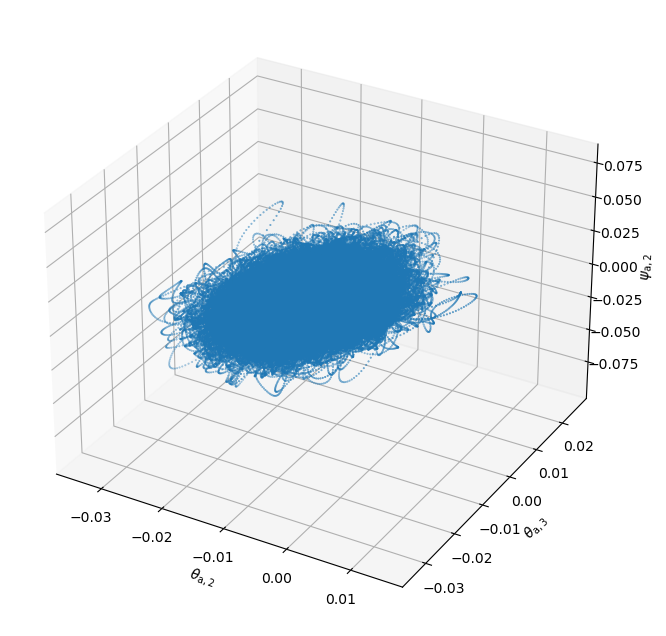

In [8]:
varx = 37
vary = 38
varz = 1

fig = plt.figure(figsize=(10, 8))
axi = fig.add_subplot(111, projection='3d')

axi.scatter(reference_traj[varx], reference_traj[vary], reference_traj[varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$')
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$')
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$');

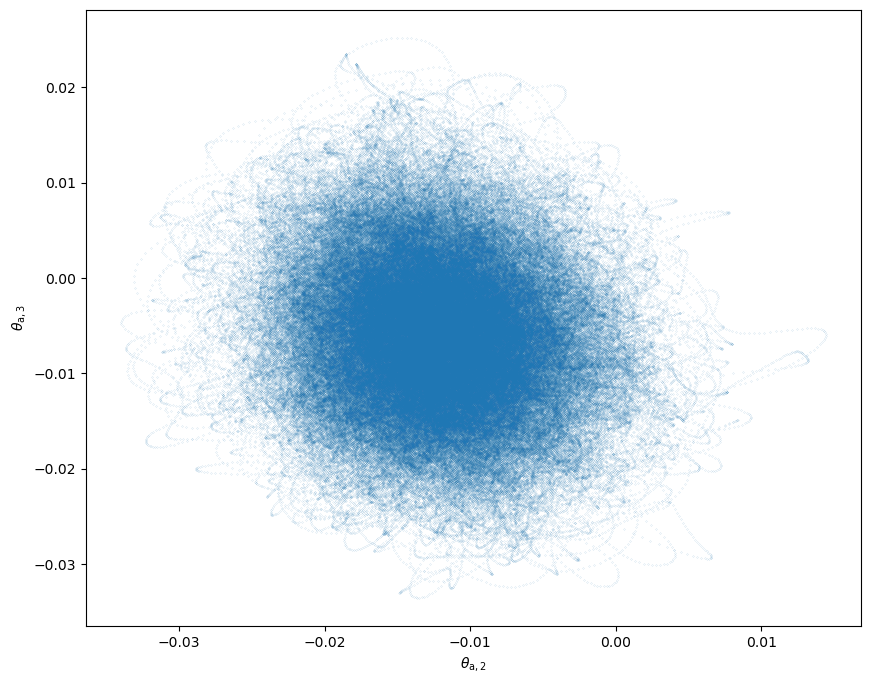

In [9]:
varx = 37
vary = 38
plt.figure(figsize=(10, 8))

plt.plot(reference_traj[varx], reference_traj[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

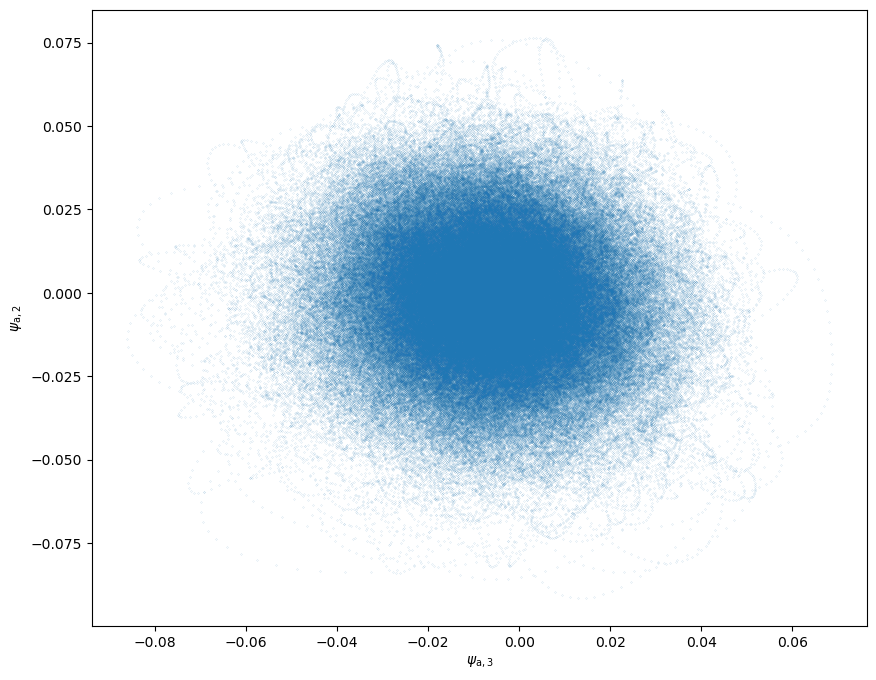

In [10]:
varx = 2
vary = 1
plt.figure(figsize=(10, 8))

plt.plot(reference_traj[varx], reference_traj[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

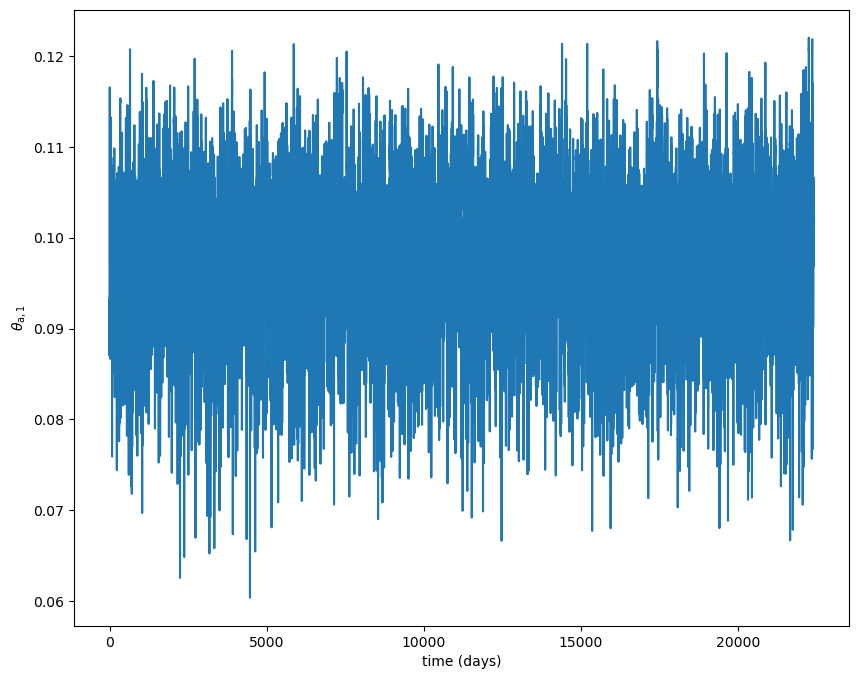

In [11]:
var = 36
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*reference_time, reference_traj[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

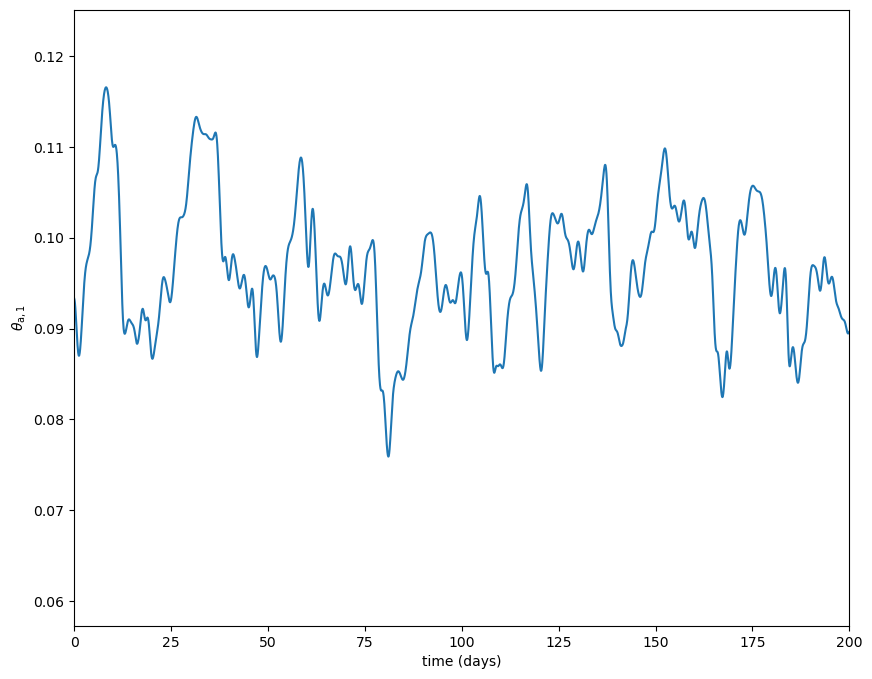

In [12]:
var = 36
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*reference_time, reference_traj[var])
plt.xlim([0,200])
plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

## Initial condition sensitivity analysis example
Instantiating a tangent linear integrator with the model tendencies

In [13]:
tgls_integrator = RungeKuttaTglsIntegrator()
tgls_integrator.set_func(f, Df)

Integrating with slightly perturbed initial conditions

In [14]:
print(f"{number_of_perturbed_trajectories = }, {model_parameters.ndim = }")
tangent_ic = 0.00001*np.random.randn(number_of_perturbed_trajectories, model_parameters.ndim)
print(f"{tangent_ic.shape = }, for example {tangent_ic[0,0] = }")

number_of_perturbed_trajectories = 10, model_parameters.ndim = 108
tangent_ic.shape = (10, 108), for example tangent_ic[0,0] = -1.2996049327018816e-05


Below we will re-use the initial conditions that are already relaxed on the attractor

In [15]:
%%time 
print(f"{write_steps = }")
tgls_integrator.integrate(0., 500., dt=dt, write_steps=write_steps, ic=ic, tg_ic=tangent_ic)

write_steps = 5
CPU times: user 27.9 ms, sys: 31.7 ms, total: 59.6 ms
Wall time: 9.65 s


Obtaining the perturbed trajectories

In [16]:
time, traj, delta = tgls_integrator.get_trajectories()
pert_traj = traj + delta
print(f"{len(model_parameters.dimensional_time*time) = }, {len(traj[var]) = }")

len(model_parameters.dimensional_time*time) = 1001, len(traj[var]) = 1001


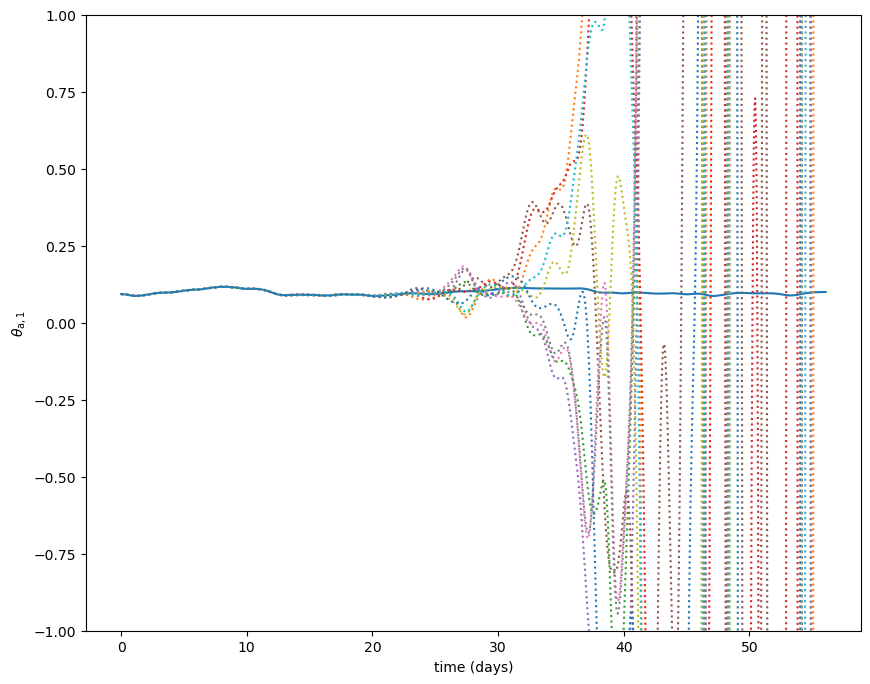

In [17]:
var = 36
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])
plt.plot(model_parameters.dimensional_time*time, pert_traj[:,var].T, ls=':')

ax = plt.gca()
plt.ylim([-1,1])
plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

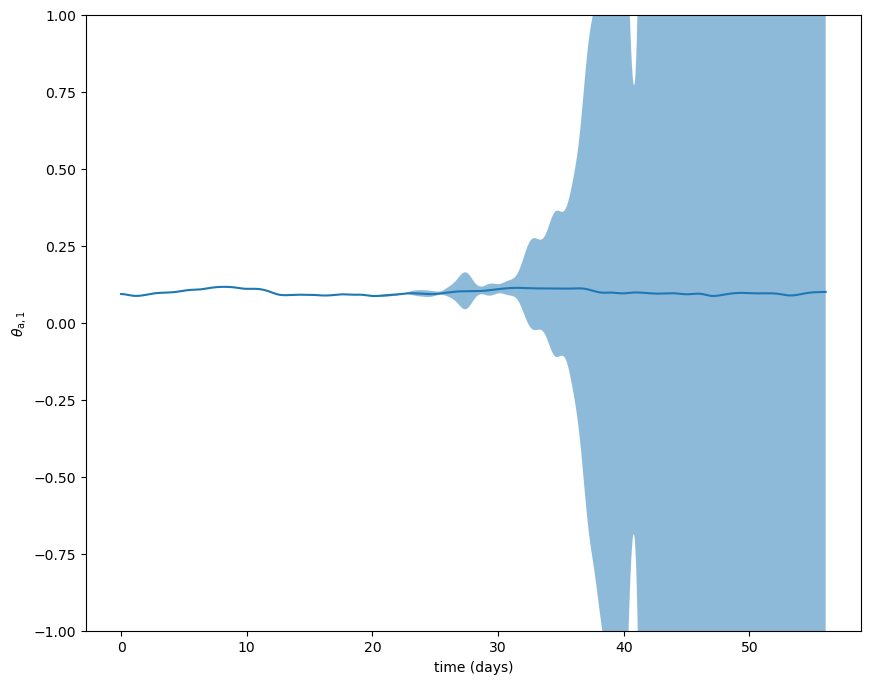

In [18]:
var = 36
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])

ax = plt.gca()
std_plot(model_parameters.dimensional_time*time, np.mean(pert_traj[:,var], axis=0), np.sqrt(np.var(pert_traj[:, var], axis=0)), ax=ax, alpha=0.5)
plt.ylim([-1,1])
plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

## Showing the resulting fields (animation)

This is an advanced feature showing the time evolution of diagnostic of the model. It shows simultaneously a scatter plot of the variable $\psi_2$ and $\psi_3$, and the geopotential height field at 500 hPa over the orographic height. Please read the documentation for more information.

Creating the diagnostics:
* For the 500hPa geopotential height:

In [19]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)

* For the nondimensional variables $\psi_2$ and $\psi_3$:

In [20]:
from qgs.diagnostics.variables import VariablesDiagnostic
variable_nondim = VariablesDiagnostic([2, 1], model_parameters, False)

In [21]:
# setting also the background
background = VariablesDiagnostic([2, 1], model_parameters, False)
background.set_data(time, traj)

Creating a multi diagnostic with both:

In [22]:
from qgs.diagnostics.multi import MultiDiagnostic
m = MultiDiagnostic(1,2)
m.add_diagnostic(variable_nondim,
                 diagnostic_kwargs={'show_time': False, 'background': background},
                 plot_kwargs={'ms': 0.2})
m.add_diagnostic(psi,
                 diagnostic_kwargs={'style': 'contour', 'contour_labels': False},
                 plot_kwargs={'colors': 'k'})
m.set_data(time, traj)

and show an interactive animation:

In [23]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})
m.animate(figsize=(20,6))

interactive(children=(IntSlider(value=500, description='time_index', max=1000), Output()), _dom_classes=('widg…

(<AxesSubplot:title={'center':'Atmospheric 500hPa geopotential height (in m) at 1.40 days'}, xlabel='$x$', ylabel='$y$'>,
 <matplotlib.colorbar.Colorbar at 0x2b0173f4d5e0>)

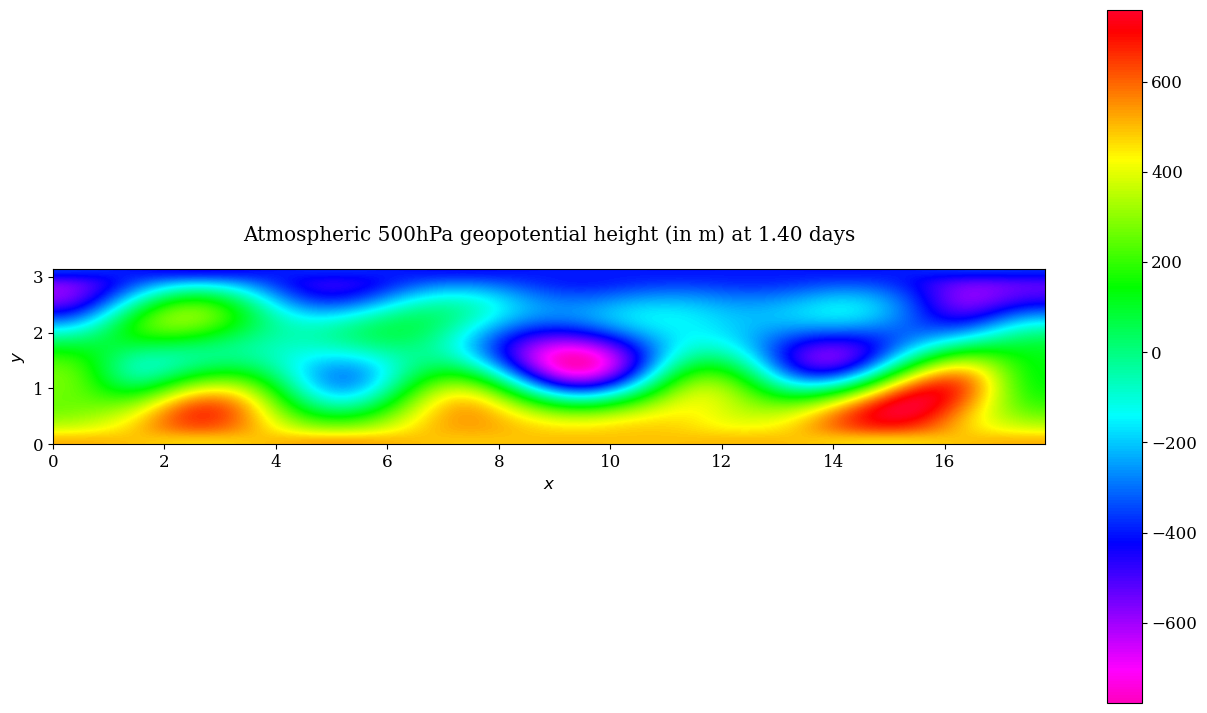

In [24]:
psi.plot(25)

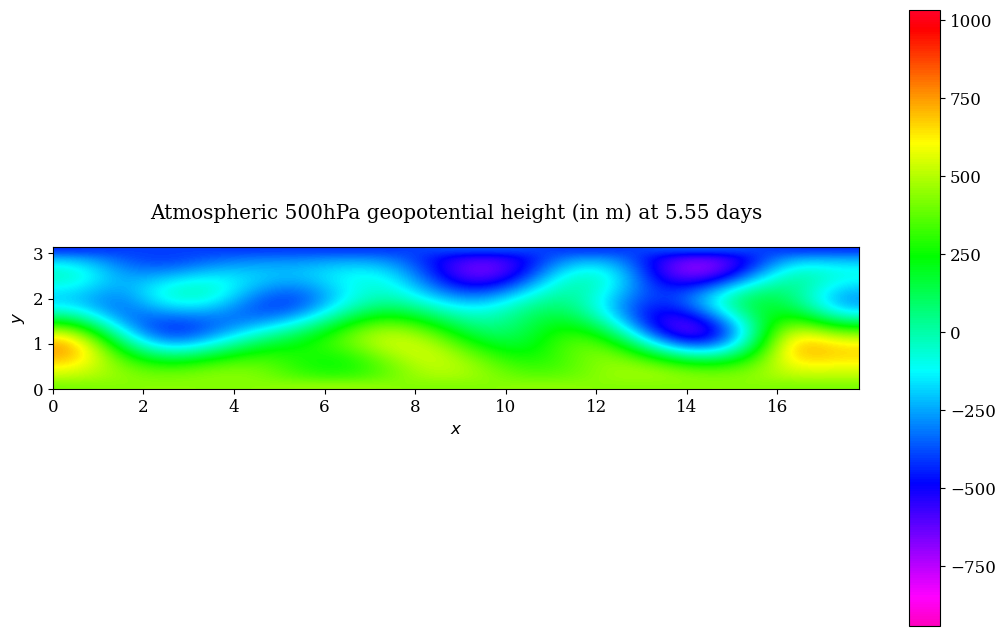

In [25]:
psi.movie(figsize=(13,8), anim_kwargs={'interval': 100, 'frames':100})

In [43]:
variable_nondim = VariablesDiagnostic([4, 3], model_parameters, False)
geopot_dim = GeopotentialHeightDifferenceDiagnostic([[[np.pi/model_parameters.scale_params.n, np.pi/4], [np.pi/model_parameters.scale_params.n, 3*np.pi/4]]],
                                                    model_parameters, True)
m1 = MultiDiagnostic(2,1)
m1.add_diagnostic(variable_nondim)
m1.add_diagnostic(geopot_dim, diagnostic_kwargs={'style':'moving-timeserie'})
m1.set_data(time, traj)
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})
m1.animate(figsize=(20,6))

interactive(children=(IntSlider(value=500, description='time_index', max=1000), Output()), _dom_classes=('widg…

* For the geopotential height difference between North and South:

400001